#### Student Name: Mai Ngo 
#### Course Name and Number: DSC 450 Database Processing for Large-Scale Analytics 
#### Final - Part 1
#### Date: 8/20/2023

## Part 1

a) Use python to download tweets from the web and save to a local text file (not into a database yet, just to a text file). This is as simple as it sounds, all you need is a for-loop that reads lines from the web and writes them into a file.

In [1]:
import urllib.request
import json
import time

def tweetText (tweetLimit, outputFile, dataURL):
    '''Take number of tweet limits, output file name, and data URL. 
    Download tweets and save to output text file.'''
    
    startTime = time.time()
    urlData = urllib.request.urlopen(dataURL)
   
    with open(outputFile, 'w', encoding='utf-8') as outfile:
        tweetCount = 0
        for tweet in urlData:
            if tweetCount >= tweetLimit: break
            tweet = tweet.decode('utf-8')
            outfile.write(tweet)
            tweetCount += 1
                
    endTime = time.time()
    runTime = endTime - startTime
    print (f"Successfully load {tweetLimit} tweets into {outputFile}")  
    return runTime

#### 130,000 tweets.

In [16]:
textURL = 'http://dbgroup.cdm.depaul.edu/DSC450/OneDayOfTweets.txt'
tweet130k_1A_runTime = tweetText (130000, '130kTweets.txt', textURL)
print(f"Query runtime 130,000 tweets Part 1A: {tweet130k_1A_runTime:4f} seconds")

Successfully load 130000 tweets into 130kTweets.txt
Query runtime 130,000 tweets Part 1A: 28.581423 seconds


#### 650,000 tweets.

In [25]:
tweet650k_1A_runTime = tweetText (650000, '650kTweets.txt', textURL)
print(f"Query runtime 650,000 tweets Part 1A: {tweet650k_1A_runTime:4f} seconds")

Successfully load 650000 tweets into 650kTweets.txt
Query runtime 650,000 tweets Part 1A: 159.163692 seconds


b) Repeat what you did in part 1-a, but instead of saving tweets to the file, populate the 3-table schema that you previously created in SQLite. Be sure to execute commit and verify that the data has been successfully loaded. Report loaded row counts for each of the 3 tables.

In [29]:
tableCommand = {'User': '''
CREATE TABLE User (
    ID               NUMBER(35),
    NAME             VARCHAR2(10000),
    SCREEN_NAME      VARCHAR2(1000),
    DESCRIPTION      VARCHAR2(100000),
    FRIENDS_COUNT    NUMBER(35),
  
    CONSTRAINT User_PK
        PRIMARY KEY(ID)
);''',
                'Geo':'''
CREATE TABLE Geo (
    GEO_ID       VARCHAR2(100),
    TYPE         VARCHAR2(100),
    LONGITUDE    NUMBER(10,6),
    LATITUDE     NUMBER(10,6),
    
    CONSTRAINT Geo_PK
        PRIMARY KEY(Geo_ID)
);''',
                'Tweet':'''
CREATE TABLE Tweet (
    CREATED_AT                 VARCHAR2(35),
    ID_STR                     VARCHAR2(35),
    TEXT                       VARCHAR2(1000),
    SOURCE                     VARCHAR2(500),
    IN_REPLY_TO_USER_ID        NUMBER(35),
    IN_REPLY_TO_SCREEN_NAME    VARCHAR2(200),
    IN_REPLY_TO_STATUS_ID      NUMBER(35),
    RETWEET_COUNT              NUMBER(50),
    CONTRIBUTORS               VARCHAR2(1000),
    USER_ID                    NUMBER(35), 
    GEO_ID                     VARCHAR2(100), 
    
    CONSTRAINT Tweet_PK
        PRIMARY KEY(ID_STR),
    CONSTRAINT Tweet_FK
        FOREIGN KEY(USER_ID)
        REFERENCES User(ID),
    CONSTRAINT Geo_FK
        FOREIGN KEY(GEO_ID)
        REFERENCES Geo(GEO_ID));'''}

In [6]:
import sqlite3

def textURL_populateSQL(tableCommands, tweetLimit, dataURL, databaseName):
    '''Takes table commands, tweet limit, data URL, and SQL database name. 
    Create corresponding tables and populate them with input data.'''
    
    connection = sqlite3.connect(databaseName)
    cursor = connection.cursor()
    
    startTime = time.time()
    urlData = urllib.request.urlopen(dataURL)

    tweetData = []
    tweetCount = 0
    for tweet in urlData:
        if tweetCount >= tweetLimit: break
        tweetDecode = tweet.decode('utf-8')
        tweetData.append(tweetDecode)
        tweetCount += 1
       
    print(f"Number of tweets retrieve: {len(tweetData)}")
    
    for tableName, tableCommand in tableCommands.items():
        cursor.execute(f"DROP TABLE IF EXISTS {tableName}")
        connection.commit()
        cursor.execute(tableCommand)
    
    userPlaceholder = "?, ?, ?, ?, ?"
    geoPlaceholder = "?, ?, ?, ?"
    tweetPlaceholder = "?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?"
    
    unique_userID = set()
    unique_geoID = set()
    unique_tweetID = set()
    
    for tweetString in tweetData:  #Iterate through each tweet.
        tweet = json.loads(tweetString)
        
        userID = int(tweet['user']['id'])
        if userID not in unique_userID:
            unique_userID.add(userID)
            cursor.execute("SELECT COUNT(*) FROM User WHERE ID = ?", (userID,))
            if cursor.fetchone()[0] == 0:
                userValues = (userID, tweet['user']['name'], tweet['user']['screen_name'], 
                              tweet['user']['description'], str(tweet['user']['friends_count']))
                cursor.execute(f"INSERT INTO User VALUES ({userPlaceholder})", userValues)
        
        if tweet['geo'] is not None:
            geoID = f"{tweet['geo']['coordinates'][0]}_{tweet['geo']['coordinates'][1]}"
            if geoID not in unique_geoID:
                unique_geoID.add(geoID)
                cursor.execute("SELECT COUNT(*) FROM Geo WHERE GEO_ID = ?", (geoID,))
                if cursor.fetchone()[0] == 0:
                    geoValues = (geoID, tweet['geo']['type'], tweet['geo']['coordinates'][0], tweet['geo']['coordinates'][1])
                    cursor.execute(f"INSERT INTO Geo VALUES ({geoPlaceholder})", geoValues)
        else:
            geoID = None
        
        tweetID = tweet['id_str']
        if tweetID not in unique_tweetID:
            unique_tweetID.add(tweetID)
            cursor.execute("SELECT COUNT(*) FROM Tweet WHERE ID_STR = ?", (tweetID,))
            if cursor.fetchone()[0] == 0:
                tweetValues = (tweet['created_at'], tweet['id_str'], tweet['text'], tweet['source'], 
                               tweet['in_reply_to_user_id_str'], tweet['in_reply_to_screen_name'], 
                               tweet['in_reply_to_status_id_str'], tweet['retweet_count'], 
                               tweet['contributors'], tweet['user']['id'], geoID)
                cursor.execute(f"INSERT INTO Tweet VALUES ({tweetPlaceholder})", tweetValues)           
                   
    connection.commit()
    connection.close()
    
    endTime = time.time()
    runTime = endTime - startTime
    print("Successfully created tables and inserted data.")
    return runTime

#### 130,000 tweets.

In [7]:
textURL = 'http://dbgroup.cdm.depaul.edu/DSC450/OneDayOfTweets.txt'
databaseName_130k = 'DSC450-Final-130k.db'
tweet130k_1B_runTime = textURL_populateSQL(tableCommand, 130000, textURL, databaseName_130k)
print(f"Query runtime 130,000 tweets Part 1B: {tweet130k_1B_runTime:4f} seconds")

Number of tweets retrieve: 130000
Successfully created tables and inserted data.
Query runtime 130,000 tweets Part 1B: 38.403263 seconds


#### Report row counts - 130k Tweets table. 

In [33]:
connection = sqlite3.connect('DSC450-Final-130k.db')
cursor = connection.cursor()

cursor.execute("SELECT COUNT(*) FROM User")
userCount_130k_1B = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Geo")
geoCount_130k_1B = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Tweet")
tweetCount_130k_1B = cursor.fetchone()[0]

print(f"130k_1B - Total count in User table: {userCount_130k_1B}")
print(f"130k_1B - Total count in Geo table: {geoCount_130k_1B}")
print(f"130k_1B - Total count in Tweet table: {tweetCount_130k_1B}")
connection.commit()
connection.close()

130k_1B - Total count in User table: 122712
130k_1B - Total count in Geo table: 2966
130k_1B - Total count in Tweet table: 129936


#### 650,000 tweets.

In [18]:
databaseName_650k = 'DSC450-Final-650k.db'
tweet650k_1B_runTime = textURL_populateSQL(tableCommand, 650000, textURL, databaseName_650k)
print(f"Query runtime 650,000 tweets Part 1B: {tweet650k_1B_runTime:4f} seconds")

Number of tweets retrieve: 650000
Successfully created tables and inserted data.
Query runtime 650,000 tweets Part 1B: 228.646491 seconds


#### Report row counts - 650k Tweets table. 

In [34]:
connection = sqlite3.connect('DSC450-Final-650k.db')
cursor = connection.cursor()

cursor.execute("SELECT COUNT(*) FROM User")
userCount_650k_1B = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Geo")
geoCount_650k_1B = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Tweet")
tweetCount_650k_1B = cursor.fetchone()[0] 

print(f"650k_1B - Total count in User table: {userCount_650k_1B}")
print(f"650k_1B - Total count in Geo table: {geoCount_650k_1B}")
print(f"650k_1B - Total count in Tweet table: {tweetCount_650k_1B}")
connection.commit()
connection.close()

650k_1B - Total count in User table: 573179
650k_1B - Total count in Geo table: 15694
650k_1B - Total count in Tweet table: 649708


c) Use your locally saved tweet file to repeat the database population step from part-c. That is, load the tweets into the 3-table database using your saved file with tweets. This is the same code as in 1-b, but reading tweets from your file, not from the web.

In [9]:
def textFile_populateSQL (tableCommands, dataFile, databaseName):
    '''Takes table commands, data text file, and SQL database name. 
    Create corresponding tables and populate them with input data.'''
    
    connection = sqlite3.connect(databaseName)  #Open the connection.
    cursor = connection.cursor()
    startTime = time.time()
    
    tweetData = []
    with open(dataFile, 'r', encoding='utf-8') as textFile:
        rows = textFile.readlines()
    for row in rows: 
        tweetData.append(row)
    print(f"Number of tweets retrieve: {len(tweetData)}")
    
    for tableName, tableCommand in tableCommands.items():
        cursor.execute(f"DROP TABLE IF EXISTS {tableName}")
        connection.commit()
        cursor.execute(tableCommand)
      
    userPlaceholder = "?, ?, ?, ?, ?"
    geoPlaceholder = "?, ?, ?, ?"
    tweetPlaceholder = "?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?"
    
    unique_userID = set()
    unique_geoID = set()
    unique_tweetID = set()
    
    for tweetString in tweetData:  #Iterate through each tweet.
        tweet = json.loads(tweetString)
        
        userID = int(tweet['user']['id'])
        if userID not in unique_userID:
            unique_userID.add(userID)
            cursor.execute("SELECT COUNT(*) FROM User WHERE ID = ?", (userID,))
            if cursor.fetchone()[0] == 0:
                userValues = (userID, tweet['user']['name'], tweet['user']['screen_name'], 
                              tweet['user']['description'], str(tweet['user']['friends_count']))
                cursor.execute(f"INSERT INTO User VALUES ({userPlaceholder})", userValues)
        
        if tweet['geo'] is not None:
            geoID = f"{tweet['geo']['coordinates'][0]}_{tweet['geo']['coordinates'][1]}"
            if geoID not in unique_geoID:
                unique_geoID.add(geoID)
                cursor.execute("SELECT COUNT(*) FROM Geo WHERE GEO_ID = ?", (geoID,))
                if cursor.fetchone()[0] == 0:
                    geoValues = (geoID, tweet['geo']['type'], tweet['geo']['coordinates'][0], tweet['geo']['coordinates'][1])
                    cursor.execute(f"INSERT INTO Geo VALUES ({geoPlaceholder})", geoValues)
        else:
            geoID = None
        
        tweetID = tweet['id_str']
        if tweetID not in unique_tweetID:
            unique_tweetID.add(tweetID)
            cursor.execute("SELECT COUNT(*) FROM Tweet WHERE ID_STR = ?", (tweetID,))
            if cursor.fetchone()[0] == 0:
                tweetValues = (tweet['created_at'], tweet['id_str'], tweet['text'], tweet['source'], 
                               tweet['in_reply_to_user_id_str'], tweet['in_reply_to_screen_name'], 
                               tweet['in_reply_to_status_id_str'], tweet['retweet_count'], 
                               tweet['contributors'], tweet['user']['id'], geoID)
                cursor.execute(f"INSERT INTO Tweet VALUES ({tweetPlaceholder})", tweetValues) 
    
    connection.commit()  #Finalize inserted data.
    connection.close()  #Close the connection.
    
    endTime = time.time()
    runTime = endTime - startTime
    print("Successfully created tables and inserted data.")
    return runTime

#### 130,000 tweets.

In [10]:
textFile_130k = '130kTweets.txt'
tweet130k_1C_runTime = textFile_populateSQL(tableCommand, textFile_130k, databaseName_130k)
print(f"Query runtime 130,000 tweets Part 1C: {tweet130k_1C_runTime:4f} seconds")

Number of tweets retrieve: 130000
Successfully created tables and inserted data.
Query runtime 130,000 tweets Part 1C: 13.213690 seconds


#### Report row counts - 130k Tweets table. 

In [32]:
connection = sqlite3.connect('DSC450-Final-130k.db')
cursor = connection.cursor()

cursor.execute("SELECT COUNT(*) FROM User")
userCount_130k_1C = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Geo")
geoCount_130k_1C = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Tweet")
tweetCount_130k_1C = cursor.fetchone()[0]

print(f"130k_1C - Total count in User table: {userCount_130k_1C}")
print(f"130k_1C - Total count in Geo table: {geoCount_130k_1C}")
print(f"130k_1C - Total count in Tweet table: {tweetCount_130k_1C}")
connection.commit()
connection.close()

130k_1C - Total count in User table: 122712
130k_1C - Total count in Geo table: 2966
130k_1C - Total count in Tweet table: 129936


#### 650,000 tweets.

In [20]:
textFile_650k = '650kTweets.txt'
tweet650k_1C_runTime = textFile_populateSQL(tableCommand, textFile_650k, databaseName_650k)
print(f"Query runtime 130,000 tweets Part 1C: {tweet650k_1C_runTime:4f} seconds")

Number of tweets retrieve: 650000
Successfully created tables and inserted data.
Query runtime 130,000 tweets Part 1C: 83.270349 seconds


#### Report row counts - 650k Tweets table. 

In [35]:
connection = sqlite3.connect('DSC450-Final-650k.db')
cursor = connection.cursor()

cursor.execute("SELECT COUNT(*) FROM User")
userCount_650k_1C = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Geo")
geoCount_650k_1C = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Tweet")
tweetCount_650k_1C = cursor.fetchone()[0]

print(f"650k_1C - Total count in User table: {userCount_650k_1C}")
print(f"650k_1C - Total count in Geo table: {geoCount_650k_1C}")
print(f"650k_1C - Total count in Tweet table: {tweetCount_650k_1C}")
connection.commit()
connection.close()

650k_1C - Total count in User table: 573179
650k_1C - Total count in Geo table: 15694
650k_1C - Total count in Tweet table: 649708


d) Repeat the same step with a batching size of 2,500 (i.e. by inserting 2,500 rows at a time with executemany instead of doing individual inserts). Since many of the tweets are missing a Geo location, its fine for the batches of Geo inserts to be smaller than 2,500. 

In [12]:
def textFile_populateSQL_batch(tableCommands, dataFile, batchSize, databaseName):
    '''Takes table commands, data text file, batch size, and SQL database name.
    Create corresponding tables and populate them with input data using placeholders.'''
    
    connection = sqlite3.connect(databaseName)
    cursor = connection.cursor()
    
    startTime = time.time()
    
    tweetData = []
    with open(dataFile, 'r', encoding='utf-8') as textFile:
        rows = textFile.readlines()
    for row in rows: 
        tweetData.append(row)
    print(f"Number of tweets retrieved: {len(tweetData)}")
    
    for tableName, tableCommand in tableCommands.items():
        cursor.execute(f"DROP TABLE IF EXISTS {tableName}")
        connection.commit()
        cursor.execute(tableCommand)
    
    userBatch = []
    geoBatch = []
    tweetBatch = []
    
    userPlaceholder = "?, ?, ?, ?, ?"
    geoPlaceholder = "?, ?, ?, ?"
    tweetPlaceholder = "?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?"
    
    unique_userID = set()
    unique_geoID = set()
    unique_tweetID = set()
    
    for tweetString in tweetData:  #Iterate through each tweet.
        tweet = json.loads(tweetString)
        
        userID = int(tweet['user']['id'])
        if userID not in unique_userID:
            unique_userID.add(userID)
            cursor.execute("SELECT COUNT(*) FROM User WHERE ID = ?", (userID,))
            if cursor.fetchone()[0] == 0:
                userValues = (userID, tweet['user']['name'], tweet['user']['screen_name'], 
                              tweet['user']['description'], str(tweet['user']['friends_count']))
                userBatch.append(userValues)
        
        if tweet['geo'] is not None:
            geoID = f"{tweet['geo']['coordinates'][0]}_{tweet['geo']['coordinates'][1]}"
            if geoID not in unique_geoID:
                unique_geoID.add(geoID)
                cursor.execute("SELECT COUNT(*) FROM Geo WHERE GEO_ID = ?", (geoID,))
                if cursor.fetchone()[0] == 0:
                    geoValues = (geoID, tweet['geo']['type'], tweet['geo']['coordinates'][0], tweet['geo']['coordinates'][1])
                    geoBatch.append(geoValues)
        else:
            geoID = None
        
        tweetID = tweet['id_str']
        if tweetID not in unique_tweetID:
            unique_tweetID.add(tweetID)
            cursor.execute("SELECT COUNT(*) FROM Tweet WHERE ID_STR = ?", (tweetID,))
            if cursor.fetchone()[0] == 0:
                tweetValues = (tweet['created_at'], tweet['id_str'], tweet['text'], tweet['source'], 
                               tweet['in_reply_to_user_id_str'], tweet['in_reply_to_screen_name'], 
                               tweet['in_reply_to_status_id_str'], tweet['retweet_count'], 
                               tweet['contributors'], tweet['user']['id'], geoID)
                tweetBatch.append(tweetValues)
        
        #Populate each batch to each table.
        if len(userBatch) == batchSize:
            cursor.executemany(f"INSERT INTO User VALUES ({userPlaceholder})", userBatch)
            userBatch = []
        if len(geoBatch) == batchSize:
            cursor.executemany(f"INSERT INTO Geo VALUES ({geoPlaceholder})", geoBatch)
            geoBatch = []
        if len(tweetBatch) == batchSize:
            cursor.executemany(f"INSERT INTO Tweet VALUES ({tweetPlaceholder})", tweetBatch)
            tweetBatch = []

    #Left over data.
    if userBatch:
        cursor.executemany(f"INSERT INTO User VALUES ({userPlaceholder})", userBatch)
    if geoBatch:
        cursor.executemany(f"INSERT INTO geo VALUES ({geoPlaceholder})", geoBatch)
    if tweetBatch:
        cursor.executemany(f"INSERT INTO Tweet VALUES ({tweetPlaceholder})", tweetBatch)
    
    connection.commit()  #Finalize inserted data.
    connection.close()
    endTime = time.time()
    runTime = endTime - startTime
    print("Successfully created tables and inserted data.")
    return runTime

#### 130,000 tweets.

In [13]:
textFile_130k = '130kTweets.txt'
databaseName_130k = 'DSC450-Final-130k.db'
tweet130k_1D_runTime = textFile_populateSQL_batch(tableCommand, textFile_130k, 2500, databaseName_130k)
print(f"Query runtime 130,000 tweets Part 1D: {tweet130k_1D_runTime:4f} seconds")

Number of tweets retrieved: 130000
Successfully created tables and inserted data.
Query runtime 130,000 tweets Part 1D: 12.240289 seconds


#### Report row counts - 130k Tweets table. 

In [36]:
connection = sqlite3.connect('DSC450-Final-130k.db')
cursor = connection.cursor()

cursor.execute("SELECT COUNT(*) FROM User")
userCount_130k_1D = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Geo")
geoCount_130k_1D = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Tweet")
tweetCount_130k_1D = cursor.fetchone()[0]

print(f"130k_1D - Total count in User table: {userCount_130k_1D}")
print(f"130k_1D - Total count in Geo table: {geoCount_130k_1D}")
print(f"130k_1D - Total count in Tweet table: {tweetCount_130k_1D}")
connection.commit()
connection.close()

130k_1D - Total count in User table: 122712
130k_1D - Total count in Geo table: 2966
130k_1D - Total count in Tweet table: 129936


#### 650,000 tweets.

In [22]:
tweet650k_1D_runTime = textFile_populateSQL_batch(tableCommand, textFile_650k, 2500, databaseName_650k)
print(f"Query runtime 650,000 tweets Part 1D: {tweet650k_1D_runTime:4f} seconds")

Number of tweets retrieved: 650000
Successfully created tables and inserted data.
Query runtime 650,000 tweets Part 1D: 76.808055 seconds


#### Report row counts - 650k Tweets table. 

In [37]:
connection = sqlite3.connect('DSC450-Final-650k.db')
cursor = connection.cursor()

cursor.execute("SELECT COUNT(*) FROM User")
userCount_650k_1D = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Geo")
geoCount_650k_1D = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM Tweet")
tweetCount_650k_1D = cursor.fetchone()[0]

print(f"650k_1D - Total count in User table: {userCount_650k_1D}")
print(f"650k_1D - Total count in Geo table: {geoCount_650k_1D}")
print(f"650k_1D - Total count in Tweet table: {tweetCount_650k_1D}")
connection.commit()
connection.close()

650k_1D - Total count in User table: 573179
650k_1D - Total count in Geo table: 15694
650k_1D - Total count in Tweet table: 649708


e) Plot the resulting runtimes (# of tweets versus runtimes) using matplotlib for 1-a, 1-b, 1-c, and 1-d. How does the runtime compare?

#### 130,000 tweets.

Certainly, download tweets from URL to a text file yields reasonable amount of time given the number of tweets. Looking at different techniques in populating table in SQL, it is more computationally expensive (longest time) to extract the tweet data directly from the URL, comparing to extracting from a textFile. Populating with batching option is the most efficient approach since it allows multiple rows to be inserted at a time. However, if we combining download + load time (Part 1A and part 1D), it turns out to be longer than directly extracting data from the URL. Therefore, it is depend on the amount of the data, errors in the data, and complexity of the query, each approach has its own perks. Perhaps extract the tweet data directly from the URL with batching option would yield the shortest running time. Just for this assignment, last approach is the most efficient since it has the shortest running time.

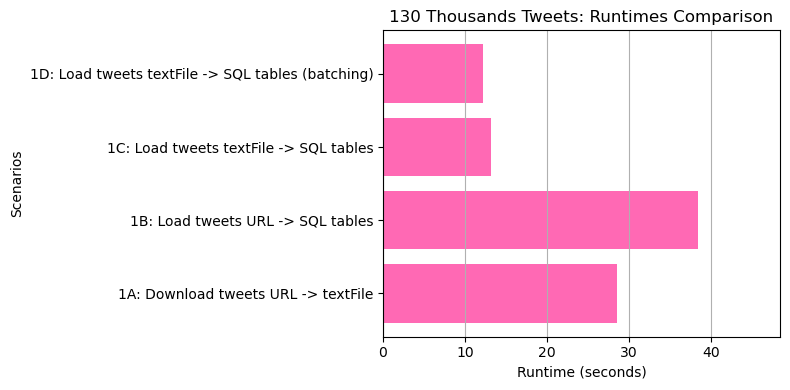

In [30]:
import matplotlib.pyplot as plt

runTimes_130k = [tweet130k_1A_runTime, tweet130k_1B_runTime, tweet130k_1C_runTime, tweet130k_1D_runTime]
labels_130k = ['1A: Download tweets URL -> textFile', '1B: Load tweets URL -> SQL tables', 
               '1C: Load tweets textFile -> SQL tables', '1D: Load tweets textFile -> SQL tables (batching)']

plt.figure(figsize=(8, 4))
plt.barh(labels_130k, runTimes_130k, color='hotpink')

plt.title('130 Thousands Tweets: Runtimes Comparison')
plt.xlabel('Runtime (seconds)')
plt.ylabel('Scenarios')

plt.xlim(0, max(runTimes_130k) + 10)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#### 650,000 tweets.

Running time distribution for 650,000 tweets is pretty similar to 130,000 tweets. Certainly, the overall time is much longer due to larger sample size (5 times larger). Time scale is almost same as data size scale as well. Same analysis, just for this assignment, last approach is the most efficient since it has the shortest running time.

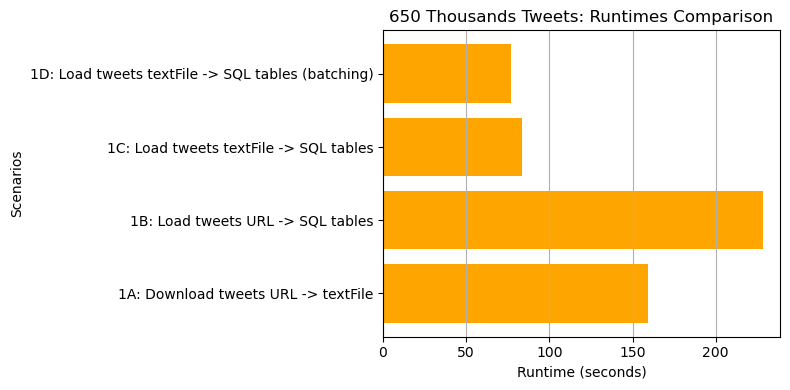

In [31]:
runTimes_650k = [tweet650k_1A_runTime, tweet650k_1B_runTime, tweet650k_1C_runTime, tweet650k_1D_runTime]
labels_650k = ['1A: Download tweets URL -> textFile', '1B: Load tweets URL -> SQL tables', 
               '1C: Load tweets textFile -> SQL tables', '1D: Load tweets textFile -> SQL tables (batching)']

plt.figure(figsize=(8, 4))
plt.barh(labels_650k, runTimes_650k, color='orange')

plt.title('650 Thousands Tweets: Runtimes Comparison')
plt.xlabel('Runtime (seconds)')
plt.ylabel('Scenarios')

plt.xlim(0, max(runTimes_650k) + 10)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Summary.

In [27]:
print ("Part 1A:")
print (f"130,000 tweets query runtime : {tweet130k_1A_runTime:4f} seconds")
print (f"650,000 tweets query runtime : {tweet650k_1A_runTime:4f} seconds \n")

print ("Part 1B:")
print (f"130,000 tweets query runtime : {tweet130k_1B_runTime:4f} seconds")
print ("\t Row count:")
print(f"\t 130k_1B - Total count in User table: {userCount_130k_1B}")
print(f"\t 130k_1B - Total count in Geo table: {geoCount_130k_1B}")
print(f"\t 130k_1B - Total count in Tweet table: {tweetCount_130k_1B}")
print (f"650,000 tweets query runtime : {tweet650k_1B_runTime:4f} seconds")
print ("\t Row count:")
print(f"\t 650k_1B - Total count in User table: {userCount_650k_1B}")
print(f"\t 650k_1B - Total count in Geo table: {geoCount_650k_1B}")
print(f"\t 650k_1B - Total count in Tweet table: {tweetCount_650k_1B} \n")

print ("Part 1C:")
print (f"130,000 tweets query runtime : {tweet130k_1C_runTime:4f} seconds")
print ("\t Row count:")
print(f"\t 130k_1C - Total count in User table: {userCount_130k_1C}")
print(f"\t 130k_1C - Total count in Geo table: {geoCount_130k_1C}")
print(f"\t 130k_1C - Total count in Tweet table: {tweetCount_130k_1C}")
print (f"650,000 tweets query runtime : {tweet650k_1C_runTime:4f} seconds")
print ("\t Row count:")
print(f"\t 650k_1C - Total count in User table: {userCount_650k_1C}")
print(f"\t 650k_1C - Total count in Geo table: {geoCount_650k_1C}")
print(f"\t 650k_1C - Total count in Tweet table: {tweetCount_650k_1C} \n")

print ("Part 1D:")
print (f"130,000 tweets query runtime : {tweet130k_1D_runTime:4f} seconds")
print ("\t Row count:")
print(f"\t 130k_1D - Total count in User table: {userCount_130k_1D}")
print(f"\t 130k_1D - Total count in Geo table: {geoCount_130k_1D}")
print(f"\t 130k_1D - Total count in Tweet table: {tweetCount_130k_1D}")
print (f"650,000 tweets query runtime : {tweet650k_1D_runTime:4f} seconds")
print ("\t Row count:")
print(f"\t 650k_1D - Total count in User table: {userCount_650k_1D}")
print(f"\t 650k_1D - Total count in Geo table: {geoCount_650k_1D}")
print(f"\t 650k_1D - Total count in Tweet table: {tweetCount_650k_1D}")

Part 1A:
130,000 tweets query runtime : 28.581423 seconds
650,000 tweets query runtime : 159.163692 seconds 

Part 1B:
130,000 tweets query runtime : 38.403263 seconds
	 Row count:
	 130k_1B - Total count in User table: 122712
	 130k_1B - Total count in Geo table: 2966
	 130k_1B - Total count in Tweet table: 129936
650,000 tweets query runtime : 228.646491 seconds
	 Row count:
	 650k_1B - Total count in User table: 573179
	 650k_1B - Total count in Geo table: 15694
	 650k_1B - Total count in Tweet table: 649708 

Part 1C:
130,000 tweets query runtime : 13.213690 seconds
	 Row count:
	 130k_1C - Total count in User table: 122712
	 130k_1C - Total count in Geo table: 2966
	 130k_1C - Total count in Tweet table: 129936
650,000 tweets query runtime : 83.270349 seconds
	 Row count:
	 650k_1C - Total count in User table: 573179
	 650k_1C - Total count in Geo table: 15694
	 650k_1C - Total count in Tweet table: 649708 

Part 1D:
130,000 tweets query runtime : 12.240289 seconds
	 Row count:
	 